In [1]:
import torch
import torch.nn as nn  
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
#The images need to be preprocessed before being fed into the network
#transform essential composes several transformations together
#ToTensor() converts the images into a pytorch tensor
#Normalize() normalizes the tensor with a mean and standard deviation
#The mean and standard deviation values are provided as a tuple for each channel in this case the means 
#and the standard deviation are 0.5 for each channel (RGB in case of CIFAR10 dataset, 1 channel in case of MNIST dataset)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128 #The number of images that will be fed into the network at once

#We then define the dataloaders for the training and testing datasets

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:50<00:00, 3392246.31it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


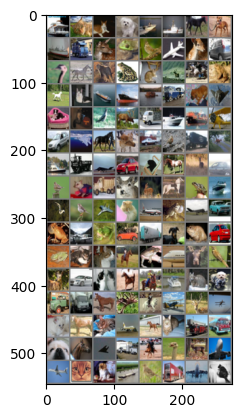

ship  cat   cat   dog   ship  ship  horse dog   ship  truck deer  frog  bird  plane deer  car   bird  horse cat   frog  cat   deer  horse frog  horse cat   ship  ship  ship  truck dog   plane dog   cat   bird  deer  truck ship  ship  plane car   plane horse deer  car   bird  truck deer  ship  truck plane car   cat   horse deer  car   bird  dog   truck deer  deer  horse frog  ship  bird  bird  plane cat   plane frog  plane car   frog  plane frog  car   truck dog   frog  car   frog  cat   cat   horse frog  plane deer  bird  deer  car   cat   horse horse ship  cat   dog   truck truck horse deer  horse plane deer  plane cat   horse cat   plane horse cat   truck truck dog   horse plane truck horse bird  deer  plane plane cat   dog   ship  bird  truck plane cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

#Note that the images are normalized and need to be denormalized before being displayed
#The function display_image() is used to display the images using imshow() function from matplotlib


def display_image(img):
    img = img / 2 + 0.5     # for each pixel we applied pixel_value <- (pixel_value - 0.5)/0.5 during normalization, this needs to be reversed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    #The images are in the format (channel, height, width) and need to be converted to (height, width, channel) for display
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
display_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
#We now define the CNN model
#The model consists of 2 convolutional layers and 3 fully connected layers
#The first Conv2D layer converts the input image into 6 channels with a kernel size of 5
#The second Conv2D layer converts the 6 channels into 16 channels with a kernel size of 5
#the MaxPool2D layer reduces the size of the image by a factor of 2 (uses a 2x2 kernel with a stride of 2)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #32x32x3 -> 28x28x6
        self.pool = nn.MaxPool2d(2, 2) #28x28x6 -> 14x14x6
        self.conv2 = nn.Conv2d(6, 16, 5) #14x14x6 -> 10x10x16
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #10x10x16 -> 5x5x16 (via pooling) which is then fed to the linear layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = CNN()

The height and width of the image after a Conv2D are calculated as 
<br>
$$H_{out} = \frac{H_{in}-k+2p}{s} + 1$$
$$W_{out} = \frac{W_{in}-k+2p}{s} + 1$$
Where $k$ is the kernel size, $p$ is the padding and $s$ is the stride.
Our model takes $32 \times 32$ and first converts them to $28 \times 28$ which are compressed to 
<br>
$14 \times 14$ by the action of Maxpool
Finally this is reduced to $10 \times 10$ and $5 \times 5$ by the action of maxpool. We flatten the image before feeding it to the linear layer.

In [7]:
import torch.optim as optim

#We define the loss function and the optimizer

criterion = nn.CrossEntropyLoss() #import appropriate loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #import appropriate optimizer with the model parameters and learning rate as arguments

In [10]:
#The training loop iterates over the dataset over a number of epochs
#We first extract the inputs and labels from the dataset and set the gradients to zero
#We then feed the inputs into the model and calculate the loss using the criterion
#The loss is then backpropagated through the network and the optimizer updates the weights
#The optimizer is then used to update the weights

#Optional: You can print the loss every n iterations to monitor the training progress using running_loss variable

epochs = 10

# CODE HERE

# Train the network
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

#Write the code to train the model for the specified number of epochs
#The code should display the loss over minibatches and display "Finished Training" after training is complete

[1,   200] loss: 2.144
[2,   200] loss: 2.043
[3,   200] loss: 1.929
[4,   200] loss: 1.847
[5,   200] loss: 1.762
[6,   200] loss: 1.684
[7,   200] loss: 1.622
[8,   200] loss: 1.560
[9,   200] loss: 1.516
[10,   200] loss: 1.480
Finished Training


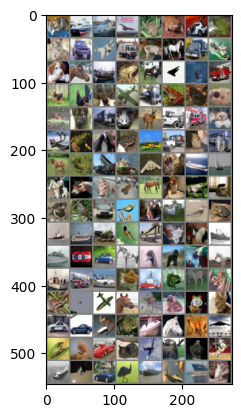

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  car   bird  cat   horse bird  frog  ship  ship  plane bird  truck cat   cat   ship  ship  car   car   horse bird  dog   bird  horse ship  truck plane cat   ship  frog  deer  frog  frog  plane plane horse deer  dog   frog  cat   car   car   cat   frog  ship  horse deer  plane frog  bird  car   cat   plane deer  bird  horse ship  cat   car   bird  ship  plane ship  cat  


In [11]:
#The model is then tested on the test dataset
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
display_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
correct = 0
total = 0
#We then iterate over the test dataset and calculate the accuracy of the model
#The accuracy is calculated as the number of correct predictions divided by the total number of images
#The model is set to evaluation mode using torch.no_grad() to disable gradient calculation

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 46 %


In [14]:
#Prepare dictionaries to store the number of correct and total predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

#Using the above code as reference, calculate the accuracy of the model for each class
#The accuracy is calculated as the number of correct predictions divided by the total number of images for each class
#display the accuracy for each class

# CODE HERE
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update correct and total predictions for each class
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

# Check the accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy of {classname:5s} : {accuracy:.2f} %')

Accuracy of the network on the 10000 test images: 46.75 %
Accuracy of plane : 54.20 %
Accuracy of car   : 70.50 %
Accuracy of bird  : 14.50 %
Accuracy of cat   : 38.40 %
Accuracy of deer  : 31.80 %
Accuracy of dog   : 40.50 %
Accuracy of frog  : 58.80 %
Accuracy of horse : 55.10 %
Accuracy of ship  : 55.60 %
Accuracy of truck : 48.10 %
